AutoEncoder and Denoiser using TensorFlow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import AdamW
from keras import Model
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

x_train_flat = x_train.reshape(-1, 784)
x_test_flat = x_test.reshape(-1, 784)

x_train_reshaped = x_train[..., np.newaxis]
x_test_reshaped = x_test[..., np.newaxis]

noise_factor = 0.2

x_train_noisy = x_train_reshaped + noise_factor * np.random.normal(0.0, 1.0, x_train_reshaped.shape)
x_test_noisy = x_test_reshaped + noise_factor * np.random.normal(0.0, 1.0, x_test_reshaped.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
def plot_graph(history, title):
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.title(title)
    plt.show()

AutoEncoder Traning

In [3]:
model = Sequential([
    layers.Input((784,)),

    layers.Dense(512, activation='swish'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(256, activation='swish'),
    layers.BatchNormalization(),

    layers.Dense(128, activation='swish', name="bottleneck_dense"),
    layers.BatchNormalization(),

    layers.Dense(256, activation='swish'),
    layers.BatchNormalization(),

    layers.Dense(512, activation='swish'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(784, activation='sigmoid'),
])


optimizer = AdamW(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy")

autoencoder_history = model.fit(
    x_train_flat,
    x_train_flat,
    epochs=15,
    batch_size=128,
    shuffle=True,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(
            patience=10,
            restore_best_weights=True,
            monitor="val_loss",
            min_delta=0.001,
            mode='min'
        ),
        ReduceLROnPlateau(
            patience=3, factor=0.5, min_lr=1e-6, monitor="val_loss", verbose=1
        ),
    ],
)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 0.4555 - val_loss: 0.2925 - learning_rate: 0.0010
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.2951 - val_loss: 0.2834 - learning_rate: 0.0010
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 0.2867 - val_loss: 0.2782 - learning_rate: 0.0010
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.2828 - val_loss: 0.2778 - learning_rate: 0.0010
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.2807 - val_loss: 0.2748 - learning_rate: 0.0010
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.2790 - val_loss: 0.2741 - learning_rate: 0.0010
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.2778 - val_loss: 0.2721 - learning_rate: 0.0010
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.2768 - val_loss: 0.2718 - learning_rate: 0.0010
Epoch 9/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.2755 - val_loss: 0.2707 - learning_rate:

AutoEncoder Result

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


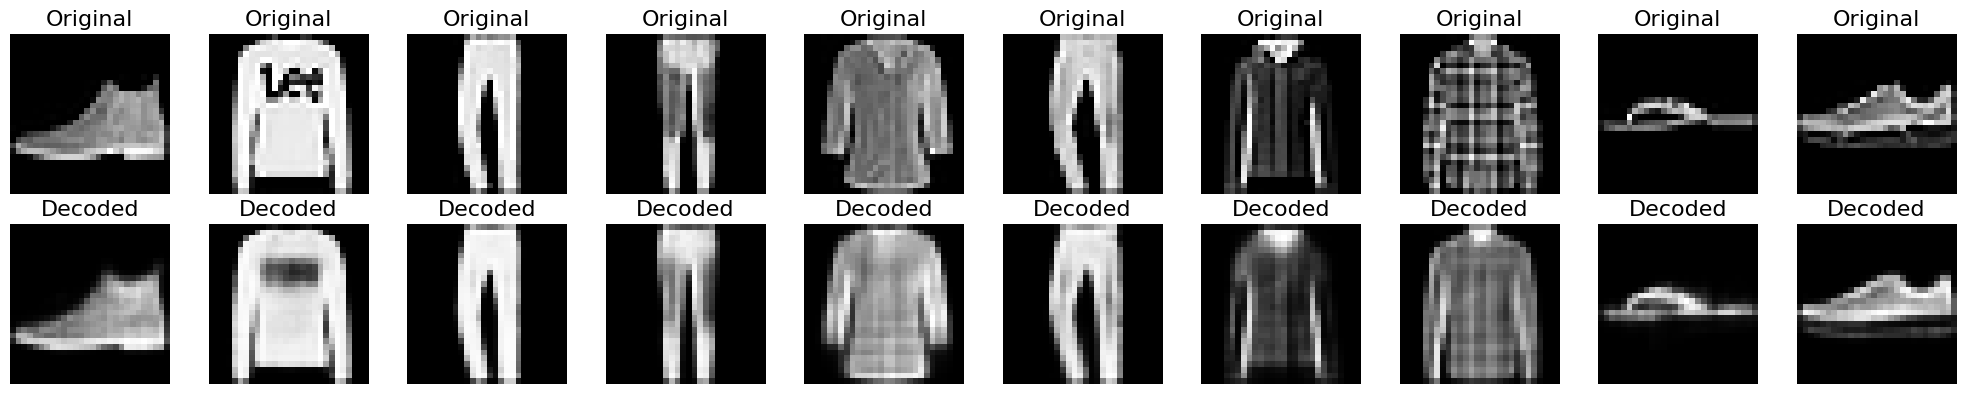

In [4]:
decoded_imgs = model.predict(x_test_flat)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
    ax.set_title("Original", fontsize=16, loc='center')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
    ax.set_title("Decoded", fontsize=16, loc='center')

plt.tight_layout()
plt.show()


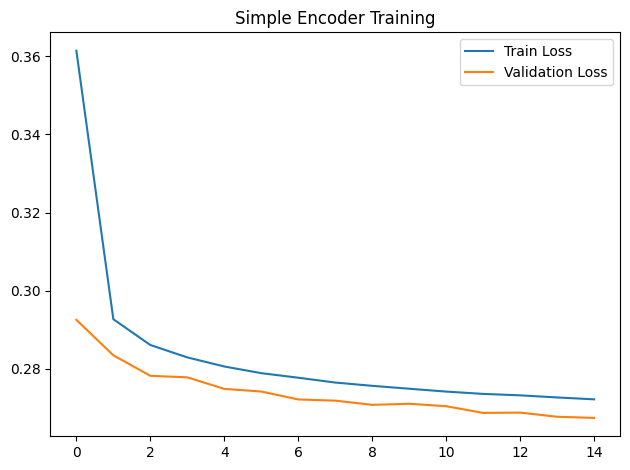

In [5]:
plot_graph(autoencoder_history, "Simple Encoder Training")

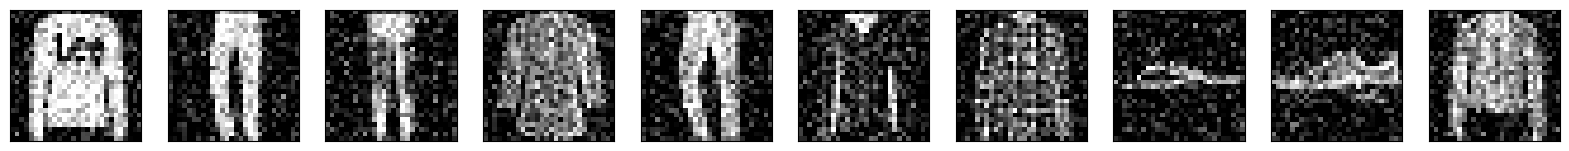

In [6]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Denoiser Training

In [7]:
denoise_model = Sequential(
    [
        layers.Input((28, 28, 1)),

        layers.Conv2D(32, (3, 3), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.BatchNormalization(),

        layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same"),
    ]
)

optimizer = AdamW(learning_rate=0.001)
denoise_model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['mse'])


denoise_history = denoise_model.fit(
    x_train_noisy,
    x_train,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(
            patience=10,
            restore_best_weights=True,
            monitor="val_loss",
            min_delta=0.001,
            mode='min'
        ),
        ReduceLROnPlateau(
            patience=3, factor=0.5, min_lr=1e-6, monitor="val_loss", verbose=1
        ),
    ],
)

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 136s 88ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0059 - val_mse: 0.0059 - learning_rate: 0.0010
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 135s 90ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0059 - val_mse: 0.0059 - learning_rate: 0.0010
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 134s 85ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0054 - val_mse: 0.0054 - learning_rate: 0.0010
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 131s 87ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0055 - val_mse: 0.0055 - learning_rate: 0.0010
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 132s 88ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0052 - val_mse: 0.0052 - learning_rate: 0.0010
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 133s 89ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0051 - val_mse: 0.0051 - learning_rate: 0.0010
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 139s 87ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0051 - val_mse: 0.

Denoiser Result

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step


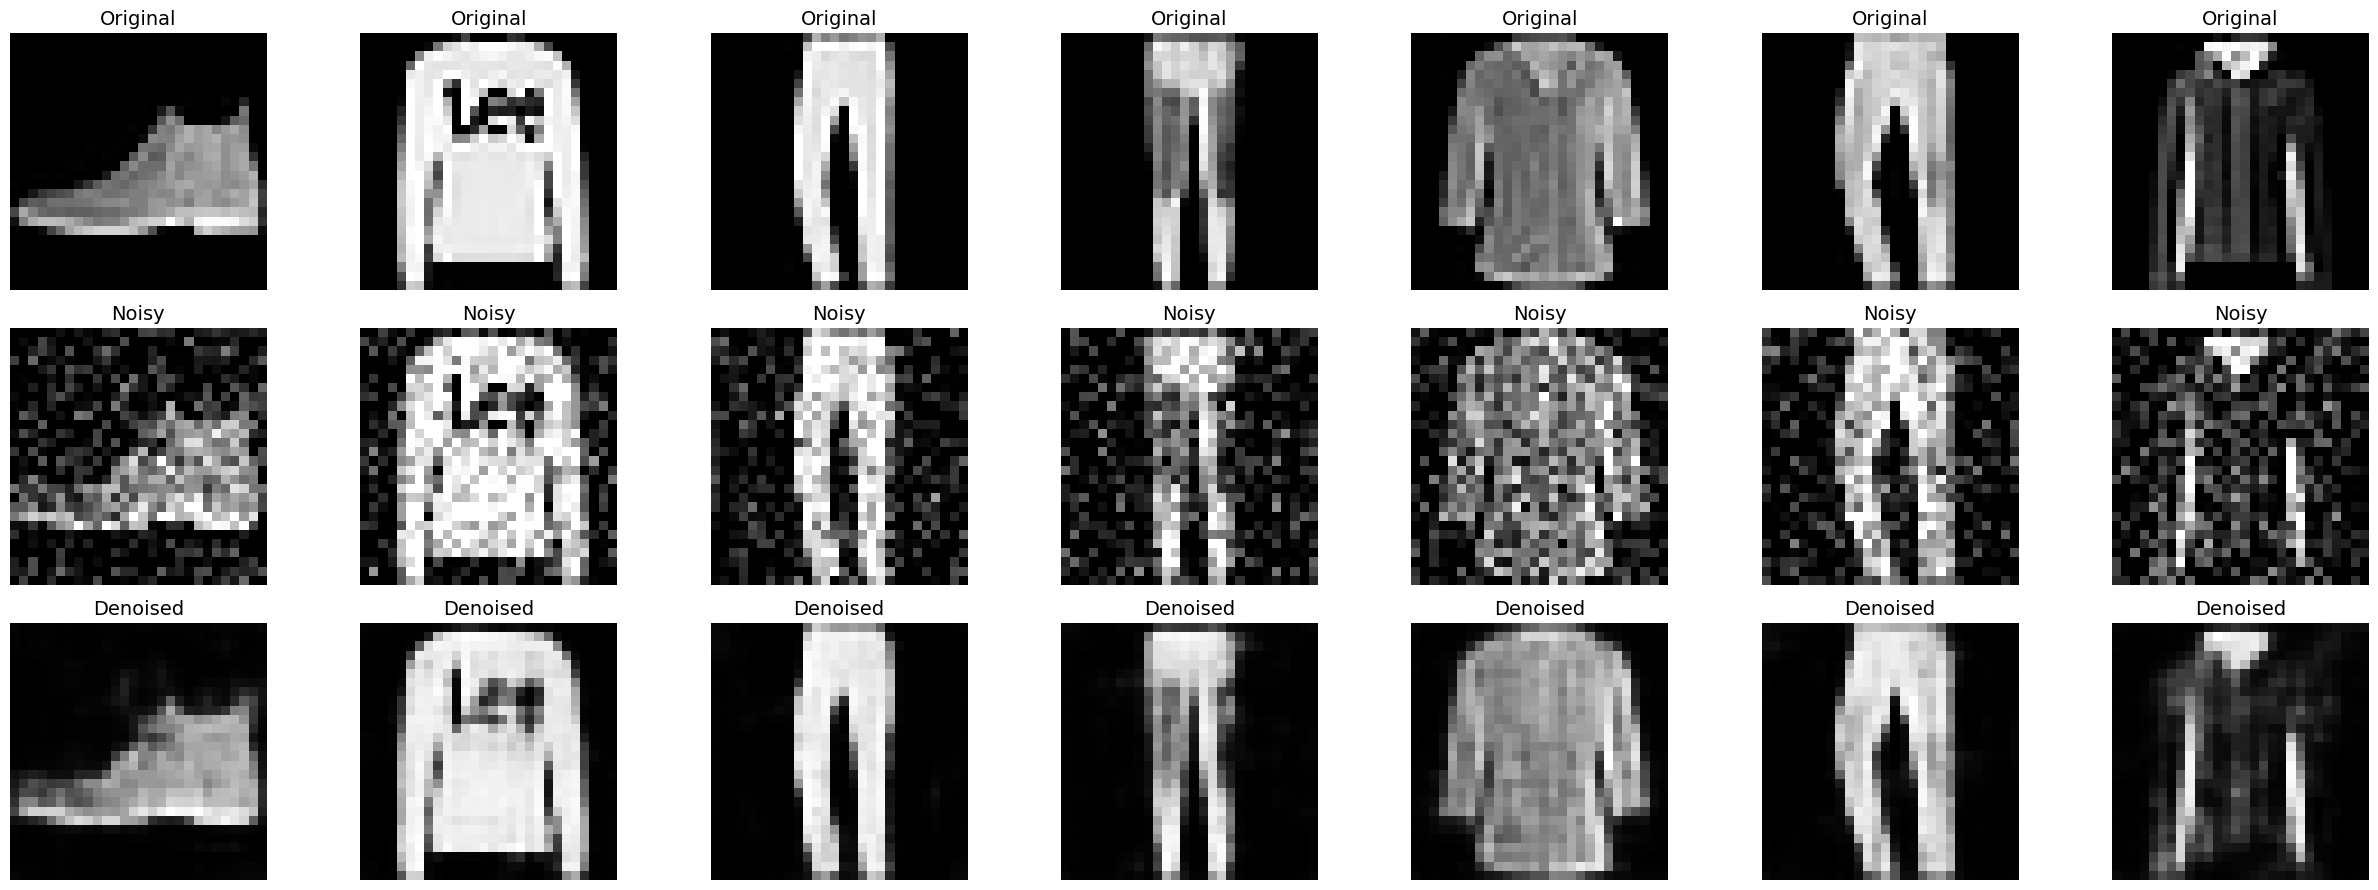

In [8]:
decoded_imgs = denoise_model.predict(x_test_noisy)

n = 7
plt.figure(figsize=(25, 9))

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    ax.imshow(tf.reshape(x_test[i], (28, 28)), cmap="gray")
    ax.set_title("Original", fontsize=14)
    ax.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    ax.imshow(tf.reshape(x_test_noisy[i], (28, 28)), cmap="gray")
    ax.set_title("Noisy", fontsize=14)
    ax.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    ax.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.set_title("Denoised", fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

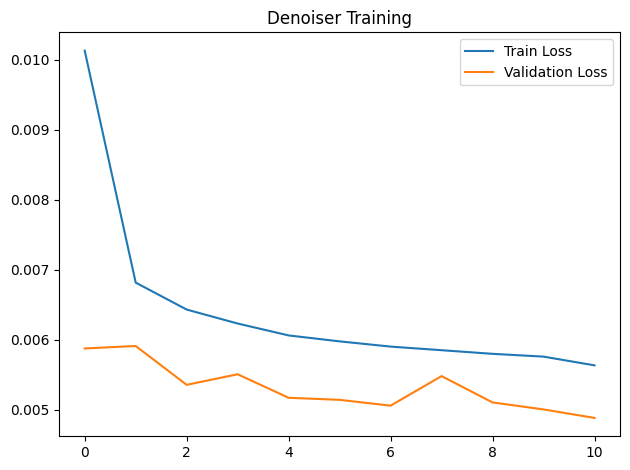

In [9]:
plot_graph(denoise_history, "Denoiser Training")

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_dense (Dense)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 784)            │       402,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,412,146 (13.02 MB)

 Trainable params: 1,136,272 (4.33 MB)

 Non-trainable params: 3,328 (13.00 KB)

 Optimizer params: 2,272,546 (8.67 MB)

In [11]:
dense_encoder = Model(inputs=model.inputs, outputs=model.get_layer("bottleneck_dense").output)

conv_encoder = Model(
    inputs=denoise_model.inputs,
    outputs=denoise_model.layers[6].output
)

In [12]:
def visualize_bottleneck(encoder, x_data, y_labels, flatten_input=False, use_tsne=True, title="Latent Space"):
    if flatten_input:
        x_data = x_data.reshape((-1, 784))

    bottleneck_output = encoder.predict(x_data)

    if len(bottleneck_output.shape) > 2:
        bottleneck_output = bottleneck_output.reshape((bottleneck_output.shape[0], -1))

    if bottleneck_output.shape[1] > 2:
        if use_tsne:
            reduced = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(bottleneck_output)
        else:
            reduced = PCA(n_components=2).fit_transform(bottleneck_output)
    else:
        reduced = bottleneck_output

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=y_labels, cmap="tab10", s=10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Bottleneck Visualization

  1/313 ━━━━━━━━━━━━━━━━━━━━ 1:18 251ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


308/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


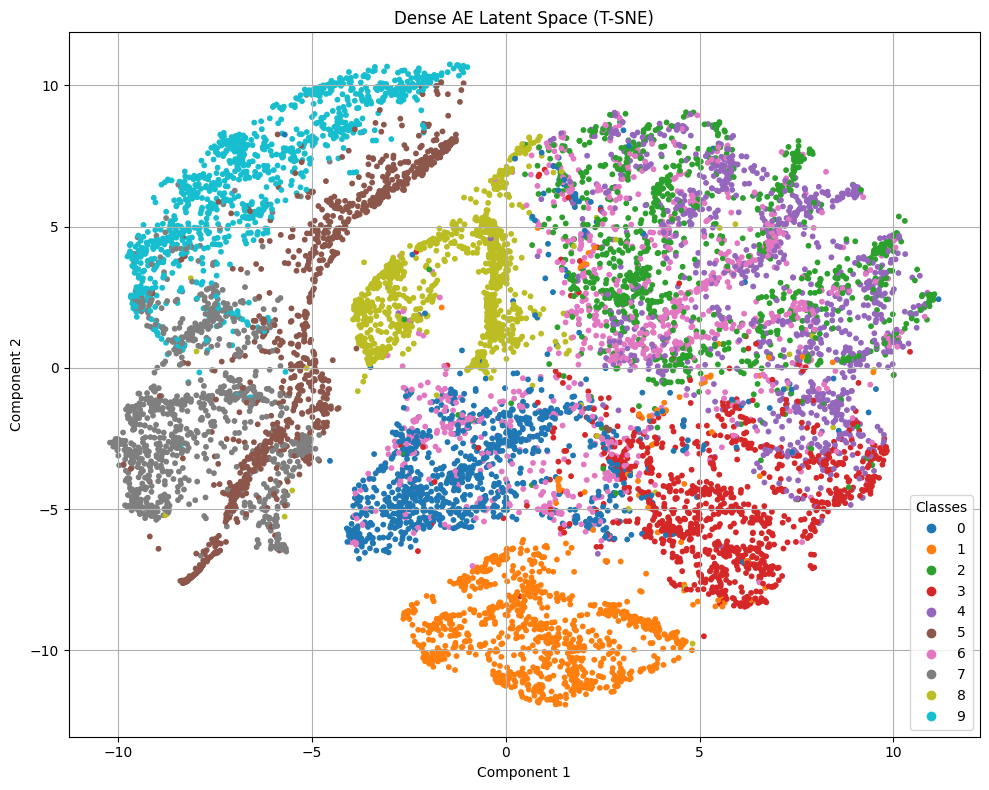

 25/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_14']
Received: inputs=Tensor(shape=(32, 28, 28, 1))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_14']
Received: inputs=Tensor(shape=(None, 28, 28, 1))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


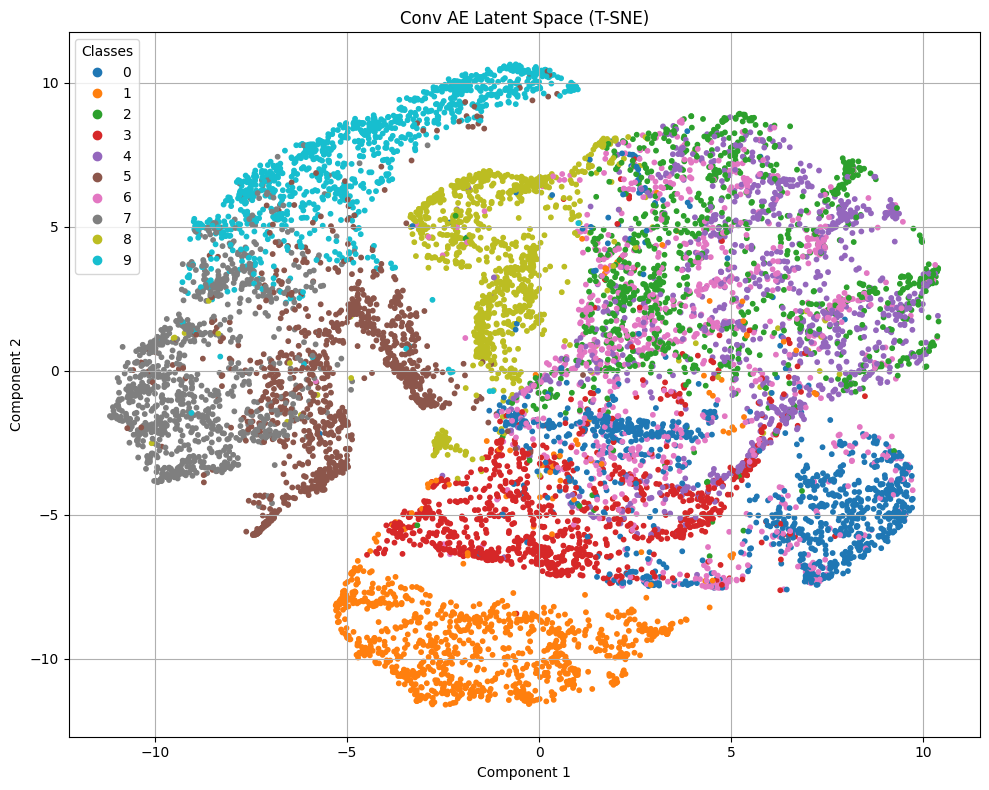

In [13]:
visualize_bottleneck(dense_encoder, x_test_flat, y_test, flatten_input=False, title="Dense AE Latent Space (T-SNE)")
visualize_bottleneck(conv_encoder, x_test_reshaped, y_test, flatten_input=False, title="Conv AE Latent Space (T-SNE)")

Summary

Summary
Model Architectures
1. Dense Autoencoder (AE)
Encoder: 784 → 512 → 256 → 128 (bottleneck)

Decoder: 128 → 256 → 512 → 784

Uses Swish activations, BatchNorm, and Dropout

2. Convolutional Denoising Autoencoder
Encoder: Stacked Conv2D with strides=2, LeakyReLU, BatchNorm, and dropout

Decoder: Conv2DTranspose layers to upsample back to original shape

Final output layer uses sigmoid for pixel reconstruction